# Test Data Analysis
Just messin around

In [23]:
# Install libraries
%pip install firebase_admin google-cloud-firestore pandas matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Firebase setup

import firebase_admin
from firebase_admin import credentials, firestore

cred = credentials.Certificate("secrets/firebase_key.json")
firebase_admin.initialize_app(cred)

db = firestore.client()

In [3]:
# Get user data

import firebase_admin
from firebase_admin import auth

email = "alexxander1611@gmail.com"

user = auth.get_user_by_email(email)
print(f'Successfully fetched user data: {user.uid}')

user_info = db.collection('Users').document(user.uid).get().to_dict()
print(user_info)


Successfully fetched user data: hiZJsylQKJNitULApBf4e9XH9vg1


E0000 00:00:1759881811.967241 9059051 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


{'uid': 'hiZJsylQKJNitULApBf4e9XH9vg1', 'email': 'Alexxander1611@gmail.com'}


In [ ]:
# Fetch IMU data

import pandas as pd

imu_coll = db.collection('UserIMU').document(user.uid).collection('Sessions')
query = imu_coll.order_by("time", direction=firestore.Query.DESCENDING).limit(1)
user_imu = query.get()[0].to_dict()

rows = []

for device, device_data in user_imu['data'].items():
	for imu_function,data in device_data.items():
		segmentIdx = 0
		for segment in data.values():
			for entry in segment:
				for simd in entry['list']:
					entry = {}
					entry["Device"] = device
					entry['Type'] = imu_function 
					entry['Time'] = simd['readTime']
					entry['Segment'] = segmentIdx
					entry["X"] = simd['read'][0]
					entry["Y"] = simd['read'][1]
					entry["Z"] = simd['read'][2]
					entry['Timestamp'] = user_imu['time']
					rows.append(entry)
			segmentIdx += 1
df = pd.DataFrame(rows)
df

,Device,Type,Time,Segment,X,Y,Z,Timestamp
0,Zeta,gyro,1.759885e+09,0,-1.262810,-1.050067,-1.658189,1.759885e+09
1,Zeta,gyro,1.759885e+09,0,-1.251463,-0.967353,-1.501646,1.759885e+09
2,Zeta,gyro,1.759885e+09,0,-1.310115,-1.033388,-1.527759,1.759885e+09
3,Zeta,gyro,1.759885e+09,0,-1.428924,-1.251728,-0.033515,1.759885e+09
4,Zeta,gyro,1.759885e+09,0,-1.406912,-1.302314,0.050840,1.759885e+09
...,...,...,...,...,...,...,...,...
3379,Sigma,planar,1.759885e+09,0,-1.004740,-1.448653,1.122755,1.759885e+09
3380,Sigma,planar,1.759885e+09,0,-0.891654,-1.454610,1.240919,1.759885e+09
3381,Sigma,planar,1.759885e+09,0,-0.839213,-1.551681,1.221973,1.759885e+09
3382,Sigma,planar,1.759885e+09,0,-0.791752,-1.632052,1.238770,1.759885e+09


In [76]:
# Visualize IMU data of a given type

gyro = df[df['Type'] == 'gyro']
zeta = df[df['Device'] == 'Zeta'].copy()
zeta_gyro = zeta[zeta['Type'] == 'gyro'].copy()
earliest = zeta_gyro['Time'].min()
zeta_gyro['Elapsed'] = zeta_gyro['Time'] - earliest

zeta_gyro.head(2)


,Device,Type,Time,Segment,X,Y,Z,Timestamp,Elapsed
0,Zeta,gyro,1.759885e+09,0,-1.262810,-1.050067,-1.658189,1.759885e+09,0.00000
1,Zeta,gyro,1.759885e+09,0,-1.251463,-0.967353,-1.501646,1.759885e+09,0.03175


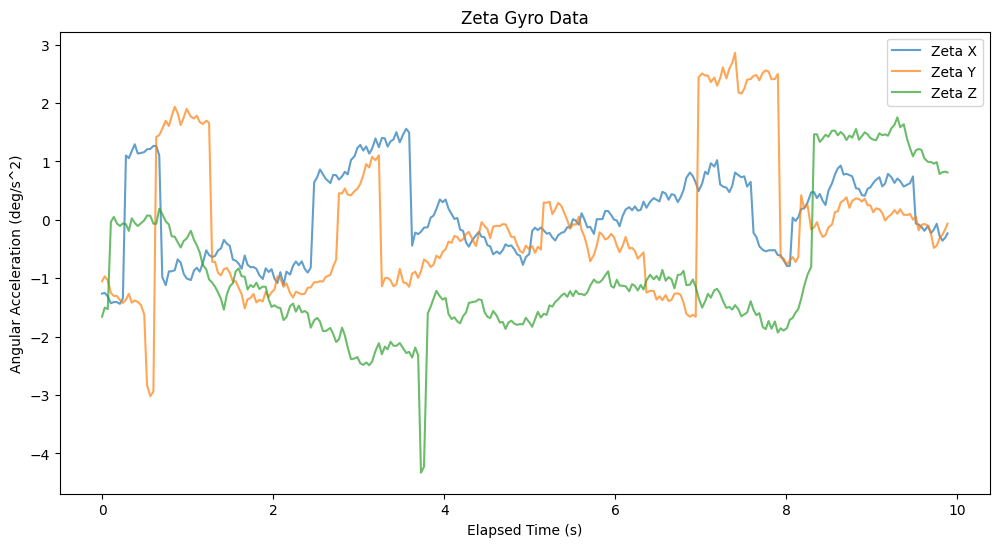

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(zeta_gyro['Elapsed'], zeta_gyro['X'], label='Zeta X', alpha=0.7)
plt.plot(zeta_gyro['Elapsed'], zeta_gyro['Y'], label='Zeta Y', alpha=0.7)
plt.plot(zeta_gyro['Elapsed'], zeta_gyro['Z'], label='Zeta Z', alpha=0.7)
plt.title('Zeta Gyro Data')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Angular Acceleration (deg/s^2)')
plt.legend()
plt.show()

Copyright © 2025 Callum Mackenzie